## LSN theoratical toy example
### Quadratic brain ROI trajectories with age

### 1. Additive initial factor: subject variability
### 2. Additive time shift: ROI variability


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from simul import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
                    


## Brain trajectories
### ROI variability: Additive time shift: ROI variability

In [ ]:
n_timepoints = 100
intercept = 5
poly_order = 2

traj1_time_shift = 50
traj2_time_shift = 60

traj1 = get_brain_trajectory(n_timepoints,intercept,traj1_time_shift,poly_order)
traj2 = get_brain_trajectory(n_timepoints,intercept,traj2_time_shift,poly_order)

t = np.arange(n_timepoints)
plt.plot(t,traj1, label="roi-1")
plt.plot(t,traj2, label="roi-2")
plt.xlabel("age")
plt.ylabel("thickness")
plt.legend()

## Generate subject-specific random samples 
### Additive initial factor: subject variability

In [ ]:
# same init factor for each ROI
n_samples = 10

roi_1 = get_traj_samples(traj1, n_samples)
roi_2 = get_traj_samples(traj2, n_samples)

palette = 'husl'
sns.set(font_scale=1)

fig, axes = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
with sns.axes_style("whitegrid"):    
    ax = axes[0]
    g = sns.heatmap(roi_1, ax=ax)
    g.set_xlabel("age")
    g.set_ylabel("sample id")
    g.set_title("ROI-1")
    ax = axes[1]
    g = sns.heatmap(roi_2, ax=ax)
    g.set_title("ROI-2")
    g.set_xlabel("age")

## Run entire toy example

In [11]:
# Traj params (Fixed)

intercept = 5
poly_order = 2
roi_maturity_min = 25
roi_maturity_max = 75
n_timepoints = 100

followup_list = [2]

verbose = False
n_jobs = 4

perf_df = pd.DataFrame(columns=["model", "n_samples", "n_regions", "followup_interval", "CV_score","test_MAE","test_r"])

for followup_interval in followup_list:
    for n_samples in [100,1000]:
        for n_regions in [100, 1000]: 
            # Region values are shifted in time
            time_shift_list = np.linspace(start=roi_maturity_min,stop=roi_maturity_max,num=n_regions)

            # Get traj(s): subject values are shifted in intercept
            traj_list = [get_brain_trajectory(n_timepoints,intercept,time_shift,poly_order) for time_shift in time_shift_list]

            # Model configs
            model_dict = {
                "LR": LinearRegression(n_jobs=n_jobs), 
                "RF": RandomForestRegressor(n_jobs=n_jobs, random_state=1), 
                # "GB": GradientBoostingRegressor(random_state=1)
                "LSN": None
            }

            # Get roi samples
            roi_list = [get_traj_samples(traj, n_samples) for traj in traj_list]

            # Get cross-sectional time data (sample with replacement)
            y_baseline, X_baseline, X_followup = get_cross_sectional_samples(roi_list, followup_interval=followup_interval)

            # normalize y
            y_followup = y_baseline + followup_interval
            
            y_baseline = y_baseline/100
            y_followup = y_followup/100

            if followup_interval > 0:
                X = np.hstack([X_baseline,X_followup])
                y = np.vstack([y_baseline,y_followup]).T
            else:
                X = X_baseline
                y = y_baseline
                
            # Split for CV and held-out test set
            n_CV = int(0.75 * n_samples)
            
            X_CV = X[:n_CV]
            X_test = X[n_CV:]

            y_CV = y[:n_CV]
            y_test = y[n_CV:]

            if verbose:
                print(f"CV data shapes, X:{X_CV.shape}, y:{y_CV.shape}")
                print(f"CV data means, X: {np.mean(X_CV):3.2f}, y:{np.mean(y_CV):3.2f}")

                print(f"test data shapes, X:{X_test.shape}, y:{y_test.shape}")
                print(f"test data means, X: {np.mean(X_test):3.2f}, y:{np.mean(y_test):3.2f}")

            # Run Models
            for model_name, model_instance in model_dict.items():
                print(f"\nSim config: n_samples: {n_samples}, n_regions= {n_regions}, followup: {followup_interval}, model: {model_name}")
                if model_name == "LSN":
                    # train
                    batch_size = 25
                    hidden_size = 100
                    
                    train_dataset = SimDataset(X_baseline[:n_CV], X_followup[:n_CV], y_baseline[:n_CV], y_followup[:n_CV])
                    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                
                    model = LSN(X_baseline.shape[1],hidden_size=hidden_size) # alternative toy model: LSN()

                    model = torch.nn.DataParallel(model)
                        
                    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
                    criterion = nn.MSELoss()
                    n_epochs = 500

                    model, batch_loss_df, epoch_loss_df = train(model,train_dataloader,optimizer,criterion,n_epochs)
                    
                    # test
                    test_dataset = SimDataset(X_baseline[n_CV:], X_followup[n_CV:], y_baseline[n_CV:], y_followup[n_CV:])
                    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

                    model.eval()                    
                    batch_pred_list, batch_loss_list = test(model, test_dataloader)
                    batch_pred_array = np.vstack(np.squeeze(batch_pred_list))
                    
                    r1 = stats.pearsonr(batch_pred_array[:,0],y_baseline[n_CV:])[0]
                    r2 = stats.pearsonr(batch_pred_array[:,1],y_followup[n_CV:])[0]
                    test_r = 0.5*(r1+r2)
                    
                    df = pd.DataFrame()
                    df["test_MAE"] = batch_loss_list
                    df["test_r"] = test_r
                    df["CV_score"] = epoch_loss_df["epoch_loss"].values[-1]
                    df["model"] = model_name
                    df["n_samples"] = n_samples
                    df["n_regions"] = n_regions
                    df["followup_interval"] = followup_interval                   
                    
                    perf_df = perf_df.append(df)

                else:
                    CV_scores, test_MAE, test_r = get_brain_age_perf(X_CV, y_CV, X_test, y_test, model_instance)
                
                    df = pd.DataFrame()
                    df["CV_score"] = CV_scores
                    df["model"] = model_name
                    df["n_samples"] = n_samples
                    df["n_regions"] = n_regions
                    df["followup_interval"] = followup_interval
                    df["test_MAE"] = test_MAE
                    df["test_r"] = test_r
                    perf_df = perf_df.append(df)


Sim config: n_samples: 100, n_regions= 100, followup: 2
epoch 499 loss: 0.0006

Sim config: n_samples: 100, n_regions= 1000, followup: 2
epoch 499 loss: 0.0000

Sim config: n_samples: 1000, n_regions= 100, followup: 2


In [9]:
perf_df.head()

,model,n_samples,n_regions,followup_interval,CV_score,test_MAE,test_r
0,LR,100,100,2,-0.016047,0.108873,1.0
1,LR,100,100,2,-0.016876,0.108873,1.0
2,LR,100,100,2,-0.013129,0.108873,1.0
3,LR,100,100,2,-0.022395,0.108873,1.0
4,LR,100,100,2,-0.015492,0.108873,1.0


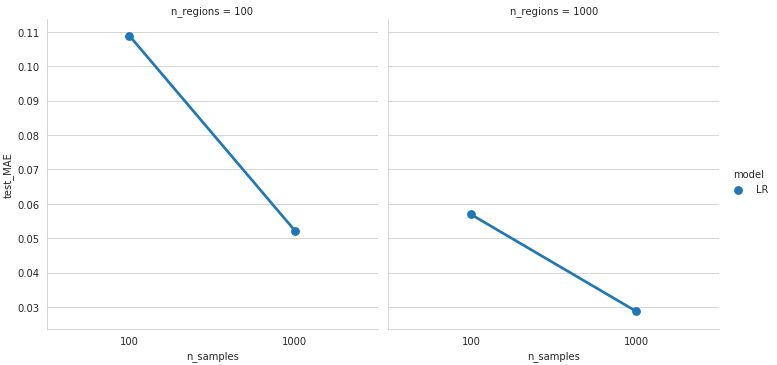

In [10]:
plot_df = perf_df.copy()
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="n_samples",hue="model",col="n_regions", kind="point", data=plot_df, aspect=1)

In [12]:
# perf_df.to_csv("results/simulation/brain_diff_sim_basemodels_run_2.csv")

# LSN_df = pd.read_csv("results/simulation/brain_diff_sim_LSN_run_1.csv")
base_df = pd.read_csv("results/simulation/brain_diff_sim_basemodels_run_2.csv")
LSN_df = perf_df.copy()

## Plots

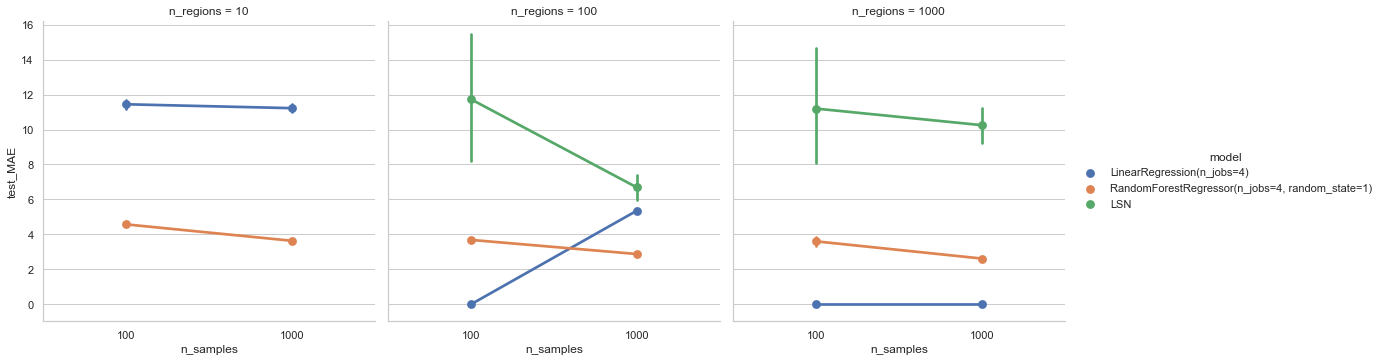

In [16]:
palette = 'husl'
sns.set(font_scale=1)

plot_df = base_df.append(LSN_df).copy()
# my_models = plot_df["model"].unique()
# plot_df['model'] = plot_df['model'].replace({my_models[2]: "LSN", my_models[3]: "LSN", my_models[4]: "LSN"})

plot_df["test_MAE"] = 100*plot_df["test_MAE"]
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="n_samples",hue="model",col="n_regions", kind="point", data=plot_df, aspect=1)

